# Numerické řešení Stokesova problému pomocí MKO

In [1]:
using PyPlot
using StaticArrays
import Base.-, Base.+, Base.*

typealias Vec2d SVector{2,Float64};

INFO: Recompiling stale cache file /home/furst/.julia/lib/v0.5/PyPlot.ji for module PyPlot.
INFO: Precompiling module StaticArrays.


In [2]:
type CartesianMesh
    nx 
    ny 
    Δx
    Δy
end

CartesianMesh(nx, ny) = CartesianMesh(nx, ny, 1.0/nx, 1.0/ny);

In [3]:
immutable Cell
    id  :: Int
    x   :: Vec2d
    vol :: Float64
end

In [4]:
immutable Face
    x     :: Vec2d
    s     :: Vec2d
    owner :: Int
    neigh :: Int
end;

In [5]:
function cell(msh::CartesianMesh, id) 
    i,j = rem(id-1, msh.nx)+1, div(id-1, msh.nx)+1
    return Cell(id, Vec2d( (i-1/2)*msh.Δx, (j-1/2)*msh.Δy ), msh.Δx*msh.Δy )
end;

cells(msh::CartesianMesh) = @task begin
    id = 1
    vol = msh.Δx * msh.Δy
    for y in range(msh.Δy/2, msh.Δy, msh.ny)
        for x in range(msh.Δx/2, msh.Δx, msh.nx)
            produce( Cell(id, Vec2d(x,y), vol) )
            id += 1
        end
    end
end;

In [6]:
m2 = CartesianMesh(2,2)

for c in cells(m2)
    println(c)
end
println()
println(cell(m2,3))

Cell(1,[0.25,0.25],0.25)
Cell(2,[0.75,0.25],0.25)
Cell(3,[0.25,0.75],0.25)
Cell(4,[0.75,0.75],0.25)

Cell(3,[0.25,0.75],0.25)


In [7]:
internalfaces(msh::CartesianMesh) = @task begin
    id(i,j) = i + (j-1)*msh.nx
    Δx, Δy = msh.Δx, msh.Δy
    
    s = Vec2d(Δy, 0.0)
    for j=1:msh.ny
        for i=1:msh.nx-1
            owner, neigh = id(i,j), id(i+1,j)
            x = Vec2d( i*Δx, (j-1/2)*Δy )
            produce( Face(x, s, owner, neigh) )
        end
    end
    
    s = Vec2d(0.0, Δx)
    for j=1:msh.ny-1
        for i=1:msh.nx
            owner, neigh = id(i,j), id(i,j+1)
            x = Vec2d( (i-1/2)*Δx, j*Δy )
            produce( Face(x, s, owner, neigh) )
        end
    end

end;

In [8]:
for f in internalfaces(m2)
    println(f)
end

Face([0.5,0.25],[0.5,0.0],1,2)
Face([0.5,0.75],[0.5,0.0],3,4)
Face([0.25,0.5],[0.0,0.5],1,3)
Face([0.75,0.5],[0.0,0.5],2,4)


In [9]:
immutable Patch
    name
    faces
end

In [10]:
function patches(msh::CartesianMesh) 
    id(i,j) = i + (j-1)*msh.nx
    Δx, Δy = msh.Δx, msh.Δy
    
    leftfaces() = @task begin
        s = Vec2d(-Δy, 0.0)
        for j=1:msh.ny
            produce( Face(Vec2d(0.0, (j-1/2)*Δy), s, id(1,j), 0) )
        end
    end

    rightfaces() = @task begin
        s = Vec2d(Δy, 0.0)
        for j=1:msh.ny
            produce( Face(Vec2d(msh.nx*Δx, (j-1/2)*Δy), s, id(msh.nx,j), 0) )
        end
    end

    bottomfaces() = @task begin
        s = Vec2d(0.0,-Δx)
        for i=1:msh.nx
            produce( Face(Vec2d((i-1/2)*Δx, 0.0), s, id(i,1), 0) )
        end
    end

    topfaces() = @task begin
        s = Vec2d(0.0,Δx)
        for i=1:msh.nx
            produce( Face(Vec2d((i-1/2)*Δx, msh.ny*Δy), s, id(i,msh.ny), 0) )
        end
    end

    return [ Patch("left", leftfaces), Patch("right", rightfaces), 
        Patch("bottom", bottomfaces), Patch("top", topfaces) ]
end;

name(p::Patch) = p.name
boundaryfaces(p::Patch) = p.faces()

boundaryfaces (generic function with 1 method)

In [11]:
for p in patches(m2)
    println("PATCH ", p.name)
    for f in boundaryfaces(p)
        println(f)
    end
    println()
end

PATCH left
Face([0.0,0.25],[-0.5,0.0],1,0)
Face([0.0,0.75],[-0.5,0.0],3,0)

PATCH right
Face([1.0,0.25],[0.5,0.0],2,0)
Face([1.0,0.75],[0.5,0.0],4,0)

PATCH bottom
Face([0.25,0.0],[0.0,-0.5],1,0)
Face([0.75,0.0],[0.0,-0.5],2,0)

PATCH top
Face([0.25,1.0],[0.0,0.5],3,0)
Face([0.75,1.0],[0.0,0.5],4,0)



In [12]:
type Equation
    A
    x
    b
end

-(eq::Equation) = Equation(-eq.A, eq.x, -eq.b);
-(eq::Equation, b::Array{Float64,1}) = Equation(eq.A, eq.x, eq.b + b);
+(eq::Equation, b::Array{Float64,1}) = Equation(eq.A, eq.x, eq.b - b);
*(a::Float64, eq::Equation) = Equation(a*eq.A, eq.x, a*eq.b);

In [13]:
function relax!(eqn::Equation, α)
    D = diag(eqn.A)
    for i=1:length(D) 
        eqn.A[i,i] /= α
    end
    eqn.b += (1-α)/α * D .* eqn.x
end;

In [14]:
function solve!(eqn::Equation)
    x = eqn.A \ eqn.b
    for i in eachindex(eqn.x)
        eqn.x[i] = x[i]
    end
end;

In [15]:
type Field
    value
    mesh
    boundarycondition
end

Field(m :: CartesianMesh, bc) = Field( zeros(m.nx*m.ny), m, bc);

asmatrix(f::Field) = reshape(f.value, (f.mesh.nx,f.mesh.ny) );

In [16]:
type Dirichlet
    value
end

type Neumann
    value
end

bndvalue(uin, Δ, bc::Dirichlet) = bc.value;
bndvalue(uin, Δ, bc::Neumann) = uin + Δ * bc.value;

ddncoeffs(Δ, bc::Dirichlet) = (-1/Δ, bc.value/Δ);
ddncoeffs(Δ, bc::Neumann) = (0, bc.value);


In [17]:
msh3 = CartesianMesh(3,3)

CartesianMesh(3,3,0.3333333333333333,0.3333333333333333)

In [18]:
function createfields(msh)
    u = Field(msh, Dict( "top"=>Dirichlet(1), "left"=>Dirichlet(0), "right"=>Dirichlet(0), "bottom"=>Dirichlet(0)) );
    v = Field(msh, Dict( "top"=>Dirichlet(0), "left"=>Dirichlet(0), "right"=>Dirichlet(0), "bottom"=>Dirichlet(0)) );
    p = Field(msh, Dict( "top"=>Neumann(0), "left"=>Neumann(0), "right"=>Neumann(0), "bottom"=>Neumann(0)) );
    return (u,v,p)
end

createfields (generic function with 1 method)

In [19]:
function laplace(ν, u)
    mesh = u.mesh
    dims = (mesh.nx, mesh.ny)
    n  = prod(dims)
    A = spzeros(n,n)
    b = zeros(n)
    
    for f in internalfaces(mesh)
        owner, neigh = f.owner, f.neigh
        
        νf = (ν[owner]+ν[neigh]) / 2.0
        
        co = cell(mesh, owner)
        cn = cell(mesh, neigh)
        
        g = νf * norm(f.s) / norm(cn.x-co.x)

        A[owner, owner] -= g / co.vol
        A[owner, neigh] += g / co.vol
            
        A[neigh, owner] += g / cn.vol
        A[neigh, neigh] -= g / cn.vol
    end
    
    for patch in patches(mesh)

        bc = u.boundarycondition[ name(patch) ]
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            
            Δ = norm(f.x - co.x)
            νf = ν[owner]
            
            a,val = ddncoeffs(Δ, bc)
            A[owner,owner] += νf * a * norm(f.s) / co.vol
            b[owner] -= νf * val * norm(f.s) / co.vol
        end
    end
    
    Equation(A, u.value, b)
end

laplace(u) = laplace(ones(u.value), u)

laplace (generic function with 2 methods)

In [20]:
function ddxi(p, dir)
    mesh = p.mesh
    dp = zeros(p.value)
    
    for f in internalfaces(mesh)
        owner = f.owner
        neigh = f.neigh
        
        pf = (p.value[owner] + p.value[neigh]) / 2.0
        
        dp[owner] += pf * f.s[dir]
        dp[neigh] -= pf * f.s[dir]
    end

    for patch in patches(mesh)
        bc = p.boundarycondition[ name(patch) ]
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            Δ = norm(f.x - co.x)
            pf = bndvalue(p.value[owner], Δ, bc)
            dp[owner] += pf * f.s[dir]
        end
    end
    
    for c in cells(mesh)
        dp[c.id] /= c.vol
    end
    
    return dp
end;

ddx(p) = ddxi(p,1);
ddy(p) = ddxi(p,2);

In [21]:
uu,_,_ = createfields(msh3);

In [22]:
uuEqn = laplace(uu)
full(uuEqn.A)

9×9 Array{Float64,2}:
 -54.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0    0.0
   9.0  -45.0    9.0    0.0    9.0    0.0    0.0    0.0    0.0
   0.0    9.0  -54.0    0.0    0.0    9.0    0.0    0.0    0.0
   9.0    0.0    0.0  -45.0    9.0    0.0    9.0    0.0    0.0
   0.0    9.0    0.0    9.0  -36.0    9.0    0.0    9.0    0.0
   0.0    0.0    9.0    0.0    9.0  -45.0    0.0    0.0    9.0
   0.0    0.0    0.0    9.0    0.0    0.0  -54.0    9.0    0.0
   0.0    0.0    0.0    0.0    9.0    0.0    9.0  -45.0    9.0
   0.0    0.0    0.0    0.0    0.0    9.0    0.0    9.0  -54.0

In [23]:
uuEqn.x

9-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
uuEqn.b

9-element Array{Float64,1}:
   0.0
   0.0
   0.0
   0.0
   0.0
   0.0
 -18.0
 -18.0
 -18.0

In [25]:
solve!(uuEqn);
uu.value

9-element Array{Float64,1}:
 0.0357143
 0.0642857
 0.0357143
 0.15     
 0.25     
 0.15     
 0.464286 
 0.635714 
 0.464286 

## Testovaci uloha

Reseni Poissonovy rovnice na ctverci

In [26]:
msh100 = CartesianMesh(100,100);

u100,_,_ = createfields(msh100);

solve!( laplace(u100) - ones(100*100));

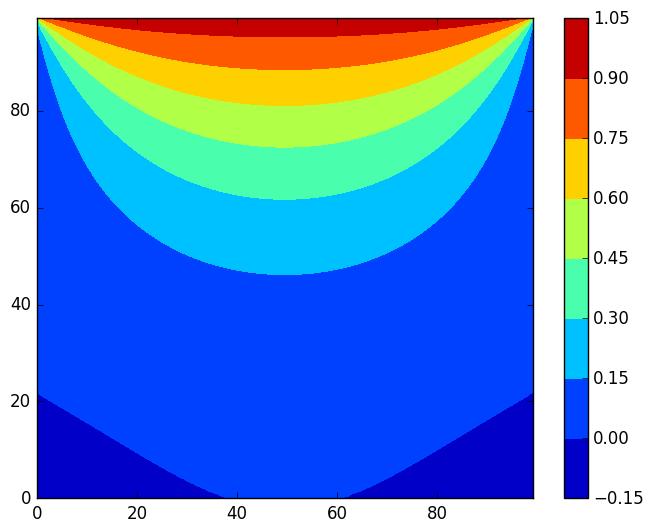

In [27]:
contourf(asmatrix(u100)'); colorbar();

In [28]:
minimum(u100.value), maximum(u100.value)

(-0.002304604666260561,0.9882345668323591)

## Algoritmus SIMPLE pro Stokesuv problem

Na jednotkovém čtevrci [0,1]x[0,1] řešme soustavu rovnic
\begin{align*}
- \Delta U &= - \nabla p, \\
\nabla U &= 0.
\end{align*}

s okrajovými podmínkami
$$
    U(x,y) = \left\{
    \begin{array}{ll}
        [0,0] & \text{pro } x \in [0,1] \land y=1,\\
        [0,0] & \text{pro } x=0 \lor x=1 \lor y=0.
    \end{array}
    \right.
$$
a
$$
    \frac{\partial p}{\partial n} = 0 \,\text{pro } x=0 \lor x=1 \lor y=0 \lor y=1.
$$


Diskretizace:
$$
    a_C U_C = \sum_{f} a_F U_F + Q_C - \nabla p_C = H(U) - \nabla p_C,
$$

a tedy

$$
    U_C = \frac{1}{a_C} H(U) - \frac{1}{a_C} \nabla p_C.
$$

Definujme
$$
    \hat{U}_C = \frac{1}{a_C} H(U).
$$

Rovnice kontinuity

$$
    0 = \nabla U_C = \nabla(\hat{U}_C - \frac{1}{a_C} \nabla p_C)
$$

a tedy

$$
    \nabla(\frac{1}{a_C} \nabla p_C) = \nabla(\hat{U}_C).
$$

In [29]:
ν = 0.01

0.01

In [30]:
msh10 = CartesianMesh(10,10);
u,v,p = createfields(msh10);

In [31]:
uEqn = (-ν) * laplace(u);
vEqn = (-ν) * laplace(v);

In [32]:
solve!(uEqn + ddx(p));
solve!(vEqn + ddy(p));

In [33]:
Ac(eq::Equation) = diag(eq.A);
H(eq::Equation) =  eq.b + Ac(eq) .* eq.x -  eq.A * eq.x;

In [34]:
ra = 1 ./ Ac(uEqn);

In [35]:
uBar = Field(ra .* H(uEqn), u.mesh, u.boundarycondition);
vBar = Field(ra .* H(vEqn), v.mesh, v.boundarycondition);

In [36]:
pEqn = laplace(ra, p) - (ddx(uBar) + ddy(vBar));
pEqn.A[1,1] += 1;

In [37]:
solve!(pEqn)

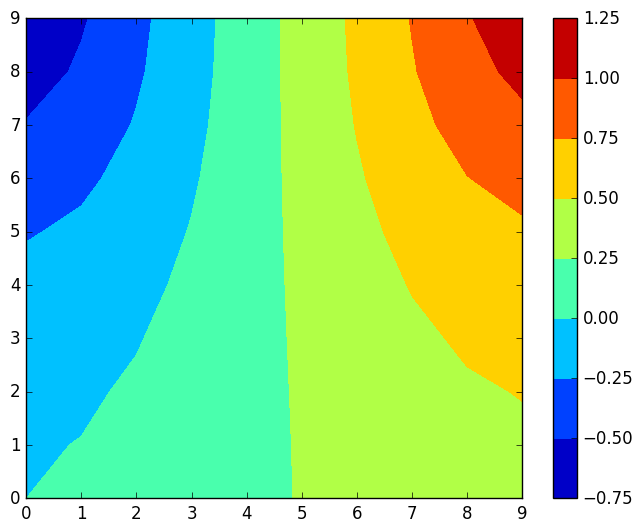

In [38]:
contourf(asmatrix(p)'); colorbar();

In [39]:
u.value = uBar.value - ra .* ddx(p);
v.value = vBar.value - ra .* ddy(p);

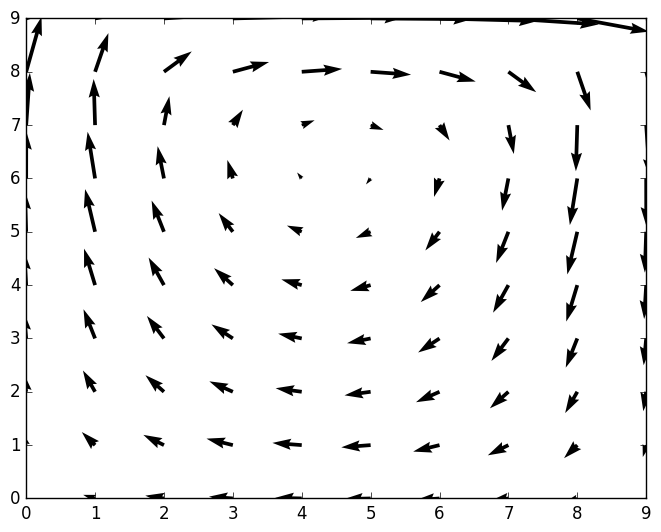

In [40]:
quiver(asmatrix(u)', asmatrix(v)');

In [41]:
reshape(ddx(u) + ddy(v), (u.mesh.nx,u.mesh.ny))

10×10 Array{Float64,2}:
  0.00262511  -0.0141141    -0.0038247    …  -0.00989964   1.44096    
  0.030829     0.0109485     0.0122017       -0.475592    -0.698952   
  0.0253652    0.0150509     0.0205853       -0.0023772    0.000958589
  0.00942416  -0.0009386    -0.000620932     -0.0059441   -0.0297914  
  0.00306911  -0.000522103  -0.000619134      0.00358826  -0.00908613 
 -0.00306911   0.000522103   0.000619134  …  -0.00358826   0.00908613 
 -0.00942416   0.0009386     0.000620932      0.0059441    0.0297914  
 -0.0253652   -0.0150509    -0.0205853        0.0023772   -0.000958589
 -0.030829    -0.0109485    -0.0122017        0.475592     0.698952   
 -0.00262511   0.0141141     0.0038247        0.00989964  -1.44096    

In [46]:
msh25 = CartesianMesh(25,25)

u,v,p = createfields(msh25)

α = 0.7
β = 0.3
ν = 1.0

for iter = 0:50
    
    uOld, vOld, pOld = copy(u.value), copy(v.value), copy(p.value)
    
    uEqn = (-ν)*laplace(u)
    vEqn = (-ν)*laplace(v)

    relax!(uEqn, α)
    relax!(vEqn, α)
    
    solve!(uEqn + ddx(p))
    solve!(vEqn + ddy(p))
    
    ra = 1 ./ Ac(uEqn);
    
    uBar = Field(ra .* H(uEqn), u.mesh, u.boundarycondition);
    vBar = Field(ra .* H(vEqn), v.mesh, v.boundarycondition);
    
    pEqn = laplace(ra, p) - (ddx(uBar) + ddy(vBar));
    pEqn.A[1,1] -= 1/(p.mesh.Δx*p.mesh.Δy)
    #pEqn.A[1,1] *= 2
    solve!(pEqn)
    
    p.value = (1-β) * pOld + β * p.value
    u.value = uBar.value - ra .* ddx(p)
    v.value = vBar.value - ra .* ddy(p)
    
    if rem(iter,5)==0
        nxny = u.mesh.nx*u.mesh.ny
        pRez = norm(pOld - p.value) / nxny
        uRez = norm(uOld - u.value) / nxny
        vRez = norm(vOld - v.value) / nxny
        println(iter, "\t", pRez, "\t", uRez, "\t", vRez)
    end
end

0	0.39543866501724373	0.0031493929847149138	0.0002963109529461849
5	0.08056242457411458	0.0006385342356502685	8.523294881671827e-5
10	0.017451214787951114	0.0002449137137054503	0.00011008027375126943
15	0.016278778503933267	0.00011883936949158103	0.00010053694538326885
20	0.007789914849081881	7.781650644726364e-5	7.240647622789568e-5
25	0.0026636364098657286	5.659210803793787e-5	5.093606143314855e-5
30	0.0006477468568542036	4.199417033631604e-5	3.728343478051864e-5
35	0.0001240300797817049	3.1375694821572826e-5	2.8296855457614968e-5
40	6.282254802270831e-5	2.3647093310448285e-5	2.1870735294818074e-5
45	6.019827881732139e-5	1.800959992166544e-5	1.7024308633445283e-5
50	6.034119432092889e-5	1.384579825167245e-5	1.32947686271494e-5


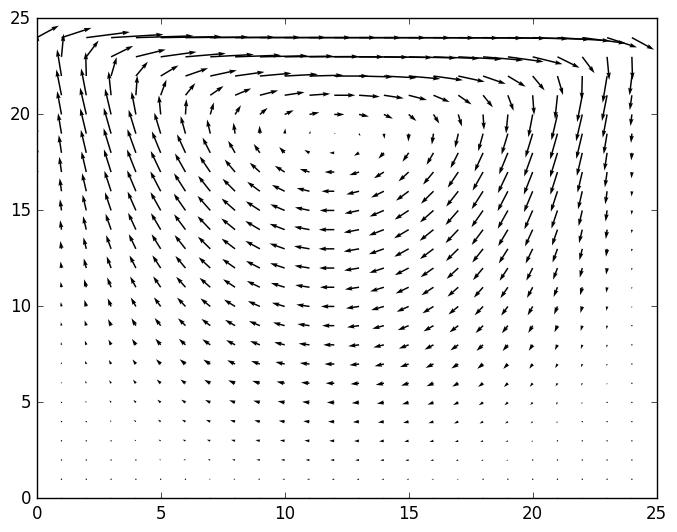

In [47]:
quiver(asmatrix(u)', asmatrix(v)');

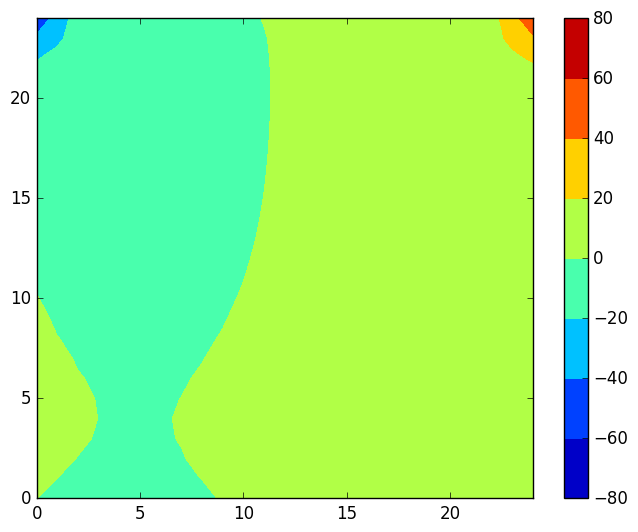

In [48]:
contourf(asmatrix(p)'); colorbar();

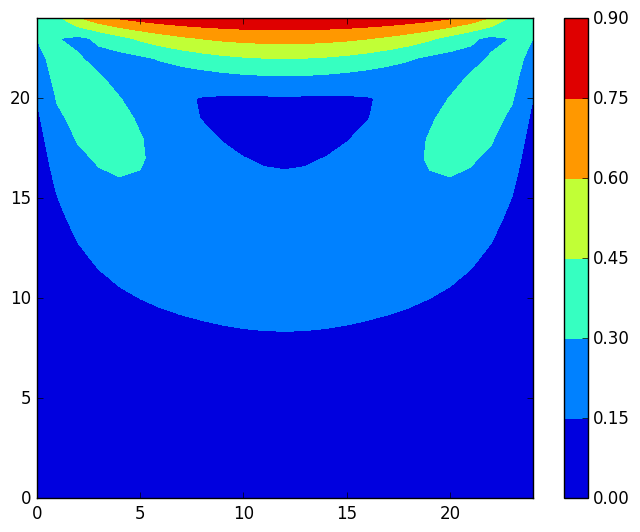

In [49]:
contourf(√(asmatrix(u).^2 + asmatrix(v).^2)'); colorbar();